# In this notebook:

* [Trained a very simple extra trees regressor on Morgan fingerprints for a solubility model](#model-training)
* [SHAP analysis of the most important bits](#shap-analysis)
* [Used bit info to highlight bits according to their SHAP value](#highlighting-bits)

In [53]:
import numpy as np
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from sklearn.ensemble import HistGradientBoostingRegressor
import shap

## Model training

For this notebook I switched to a HistGradientBoostingRegressor as the ExtraTreesRegressor was causing issues with the SHAP analysis. A quick model was trained on Morgan fingerprints for each compound to predict log solubility. No need for a validation or test set as we're not so worried about performance for this section.

In [2]:
# Combined datasets
train_data = pd.read_csv('../data/processed/train_smiles.csv')
test_data = pd.read_csv('../data/processed/test_smiles.csv')
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
# Generate features
mols = [Chem.MolFromSmiles(x) for x in all_data.smiles]
fps =  [list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)) for mol in mols]
descriptor_df = pd.DataFrame(fps, columns=[f"fp_{x}" for x in range(len(fps[0]))])
# Train model
hgbr = HistGradientBoostingRegressor()
hgbr.fit(descriptor_df, all_data.y_true)

HistGradientBoostingRegressor()

## SHAP analysis

[SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap#citations) is a game theoretic approach to explain the output of any machine learning model. A TreeExplainer was used for the model trained above. For each molecule, each bit position in the Morgan fingerprint has an associated SHAP value, which are plotted on the summary plot. The bit positions are on the y-axis in order of importance, with red points indicate a 1 at that bit position, and blue points indicate a 0 at that position. Points to the left of the line indicate a negative impact on the model output value (lower solubility), and points to the right of the time indicate a positive impact. For the most important bit position (561) the red points (1 in that bit position) reduce the solubility.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


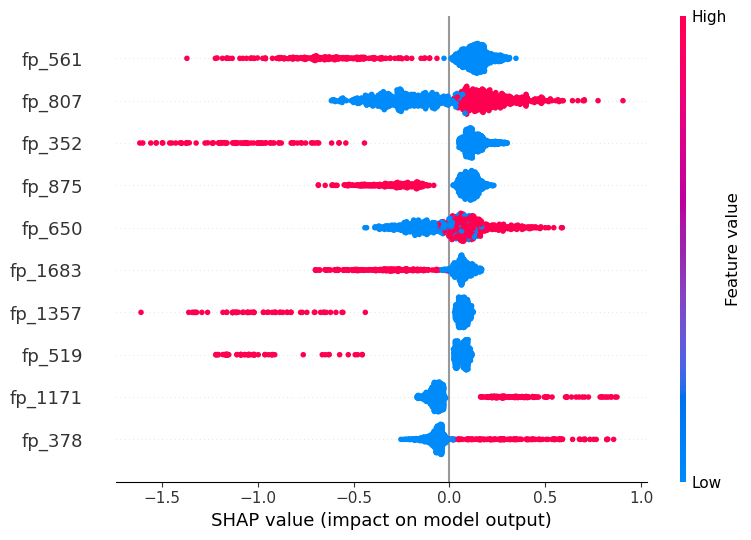

In [3]:
explainer = shap.TreeExplainer(hgbr)
shap_values = explainer.shap_values(descriptor_df)
shap.summary_plot(shap_values, descriptor_df, max_display=10)

## Highlighting bits

For 5 random compounds, for each each positive bit (1) in the Morgan fingerprint, the associated structure was highlighted according the the SHAP value. Green highlighted atoms and groups improve the solubility, and pink highlighed atoms and groups reduce solubility.

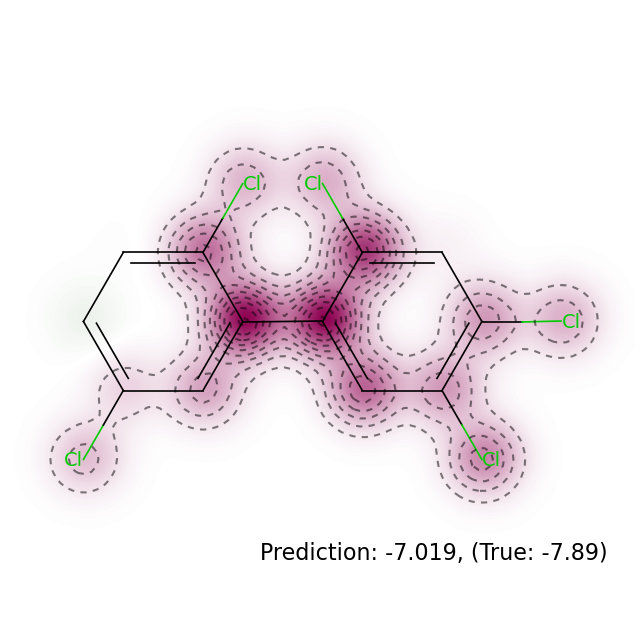

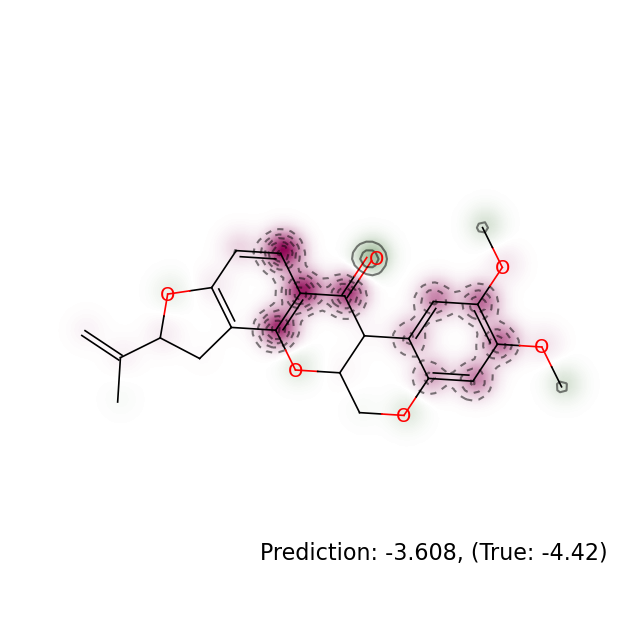

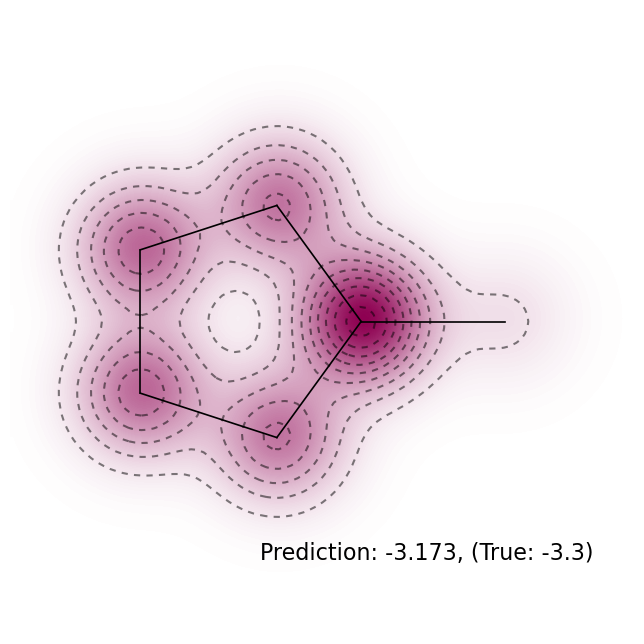

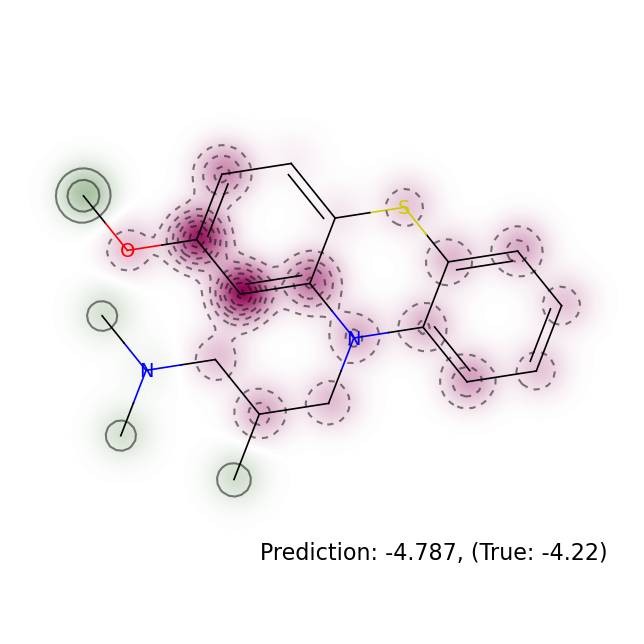

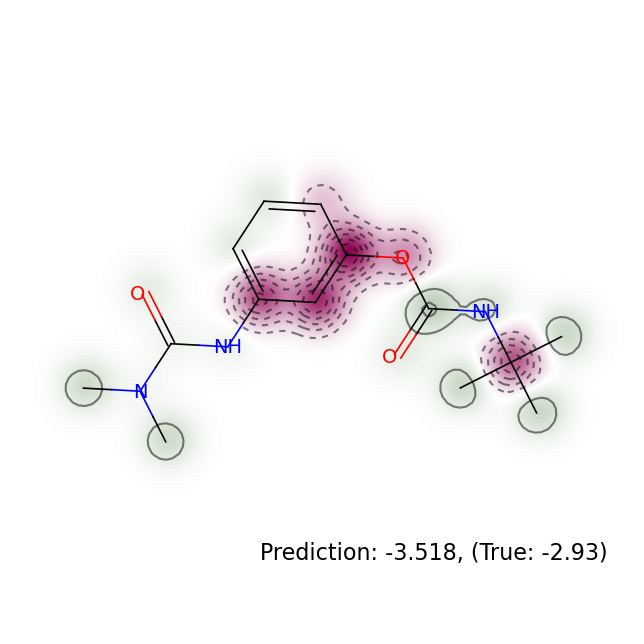

In [62]:
# Select 5 random compounds
sample = all_data.sample(5)

for ind, row in sample.iterrows():
    mol = Chem.MolFromSmiles(row.smiles)

    # Find molecule bits
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
    morg = np.array(fp)
    df = pd.DataFrame(morg.reshape(1, -1), columns=[f"fp_{x}" for x in range(len(fps[0]))])

    # Make prediction
    prediction = hgbr.predict(df)

    # Extract shap values for each Morgan bit
    explainer = shap.Explainer(hgbr)
    shap_vals = explainer(morg)
    important_bits = {}
    for index, bit in enumerate(shap_vals.values):
        important_bits[index] = bit

    # For each bit, for each atom, add shap value
    atoms = {}
    for bit in (bi.keys()):
        for atom, rad in bi[bit]:
            if rad == 0:
                if atom not in atoms:
                    atoms[atom] = important_bits[bit]
                else:
                    atoms[atom] += important_bits[bit]
            else:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom)
                amap = {}
                submol = Chem.PathToSubmol(mol, env, atomMap=amap)
                for atom2 in amap.keys():
                    if atom2 not in atoms:
                        atoms[atom2] = important_bits[bit]
                    else:
                        atoms[atom2] += important_bits[bit]
        

    # Display image of molecule with atoms highlighted according to shap v|alue
    contribs = []
    for i in range(mol.GetNumAtoms()):
        if i in atoms:
            contribs.append(atoms[i])
        else:
            contribs.append(0)
       
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, contourLines=10)
    fig.text(1,0.3,
            f'Prediction: {prediction[0]:.3f}, (True: {row.y_true})', 
            fontdict={
            'size': 16,
            }
    )